Process images

In [1]:
import os
from os.path import exists
import pandas as pd
import numpy as np
import cv2

# Import function to extract features
from extract_features import  process_images

#-------------------
# Main script
#-------------------

# Defining paths to metadata, images and their masks
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_train'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_train'    

# Defining the path to store the features
file_features = 'features/features_original.csv'
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']

#Processing images and saving annotations to csv
df_features=process_images(file_data, path_image, path_mask,feature_names)
df_features.to_csv(file_features, index=False)

Train classifier

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB

#from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pickle



metadata_df = pd.read_csv(file_data)

#Merging created annotations with patiend details
combined_df = df_features.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')
if combined_df.isnull().values.any():
    raise ValueError("NaN values detected after merge! Check the data integrity.")

# Preparing the dataset

# X - features evaluation
X = combined_df[feature_names].to_numpy()
# Y - patient diagnistic assuming that 'BCC' , 'MEL' and 'SCC' are cancerous
y = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')
patient_id = combined_df['patient_id'].values

# Preparing cross-validation
num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)

# Initialize classifiers
classifiers = [
    KNeighborsClassifier(1), #classifier 0
    KNeighborsClassifier(5), #classifier 1
    RandomForestClassifier(n_estimators=100, random_state=42), #classifier 2
    GradientBoostingClassifier(n_estimators=100, random_state=42), #classifier 3
    AdaBoostClassifier(n_estimators=100, random_state=42), #classifier 4
    DecisionTreeClassifier(random_state=42), #classifier 5
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)), #classifier 6
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced')), #classifier 7
    make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)), #classifier 8
    GaussianNB() #classifier 9
]

# Initializing accuracy storage
acc_val = np.empty((num_folds, len(classifiers)))
classifier_names = []

# Performing cross-validation
for j, clf in enumerate(classifiers):
    classifier_name = (clf.named_steps['svc'].__class__.__name__ if 'pipeline' in str(clf)
                       else clf.__class__.__name__)
    classifier_names.append(classifier_name)
    fold_accuracies = []
    
    for i, (train_index, val_index) in enumerate(group_kfold.split(X, y, patient_id)):
        x_train, y_train = X[train_index], y[train_index]
        x_val, y_val = X[val_index], y[val_index]
        
        # Fitting and predicting
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
        
        # Saving the classifier after training on this fold
        fold_filename = f'classifier_{j}_fold_{i}.sav'
        pickle.dump(clf, open(fold_filename, 'wb'))
    
    acc_val[:, j] = fold_accuracies

# Calculating average accuracy for each classifier
average_acc = np.mean(acc_val, axis=0)
for idx, acc in enumerate(average_acc):
    print(f'Classifier {idx + 1} ({classifier_names[idx]}): average accuracy={acc:.3f}')

# Saving and evaluating each classifier on the full dataset
eval_results = {}
for idx, clf in enumerate(classifiers):
    classifier_name = classifier_names[idx]
    classifier_filename = f'classifier_{idx}.sav'
    
    # Saving classifier
    pickle.dump(clf, open(classifier_filename, 'wb'))
    
    # Loading classifier
    loaded_clf = pickle.load(open(classifier_filename, 'rb'))
    
    # Predicting on the full dataset and calculating evaluation metrics
    y_pred = loaded_clf.predict(X)
    acc = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    
    eval_results[classifier_name] = {'accuracy': acc, 'report': clf_report}

# Displaying evaluation results
for clf_name, results in eval_results.items():
    print(f"Results for {clf_name}:")
    print(f"Accuracy: {results['accuracy']}")
    #print(f"Classification Report:\n{results['report']}\n")

c:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\P

Classifier 1 (KNeighborsClassifier): average accuracy=0.522
Classifier 2 (KNeighborsClassifier): average accuracy=0.527
Classifier 3 (RandomForestClassifier): average accuracy=0.526
Classifier 4 (GradientBoostingClassifier): average accuracy=0.589
Classifier 5 (AdaBoostClassifier): average accuracy=0.591
Classifier 6 (DecisionTreeClassifier): average accuracy=0.528
Classifier 7 (Pipeline): average accuracy=0.587
Classifier 8 (Pipeline): average accuracy=0.495
Classifier 9 (Pipeline): average accuracy=0.543
Classifier 10 (GaussianNB): average accuracy=0.567
Results for KNeighborsClassifier:
Accuracy: 0.6725798276735935
Results for RandomForestClassifier:
Accuracy: 0.8261530663963508
Results for GradientBoostingClassifier:
Accuracy: 0.6614292954891029
Results for AdaBoostClassifier:
Accuracy: 0.6249366447034972
Results for DecisionTreeClassifier:
Accuracy: 0.8236188545362392
Results for Pipeline:
Accuracy: 0.5215408008109478
Results for GaussianNB:
Accuracy: 0.41358337557019764


Evaluate classifier

In [5]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import glob

#Defining path to metadata and testing set
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_evaluate'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_evaluate'    

#Processing images
features_df = process_images(file_data, path_image, path_mask,feature_names)
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']

# Merging features with metadata 
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Preparing the dataset
X = combined_df[feature_names].to_numpy()
y = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')

patient_id = combined_df['patient_id']

# Function to load a classifier and evaluate it
def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    # Predicting the labels and calculating accuracy and confusion matrix
    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)
    
    return accuracy, cm

# List of classifier filenames
classifier_filenames = [f'classifier_{i}.sav' for i in range(len(os.listdir(r"C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024")))]

# Evaluate all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    print(f"Results for {model_filename}:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)


Loaded classifier from classifier_0.sav
Results for classifier_0.sav:
Accuracy: 0.5748031496062992
Confusion Matrix:
 [[46 31]
 [23 27]]
Loaded classifier from classifier_1.sav
Results for classifier_1.sav:
Accuracy: 0.5354330708661418
Confusion Matrix:
 [[52 25]
 [34 16]]
Loaded classifier from classifier_2.sav
Results for classifier_2.sav:
Accuracy: 0.5275590551181102
Confusion Matrix:
 [[46 31]
 [29 21]]
Loaded classifier from classifier_3.sav
Results for classifier_3.sav:
Accuracy: 0.5433070866141733
Confusion Matrix:
 [[59 18]
 [40 10]]
Loaded classifier from classifier_4.sav
Results for classifier_4.sav:
Accuracy: 0.5590551181102362
Confusion Matrix:
 [[61 16]
 [40 10]]
Loaded classifier from classifier_5.sav
Results for classifier_5.sav:
Accuracy: 0.5275590551181102
Confusion Matrix:
 [[49 28]
 [32 18]]
Loaded classifier from classifier_6.sav
Results for classifier_6.sav:
Accuracy: 0.6062992125984252
Confusion Matrix:
 [[77  0]
 [50  0]]
Loaded classifier from classifier_7.sav
R

Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0.sav


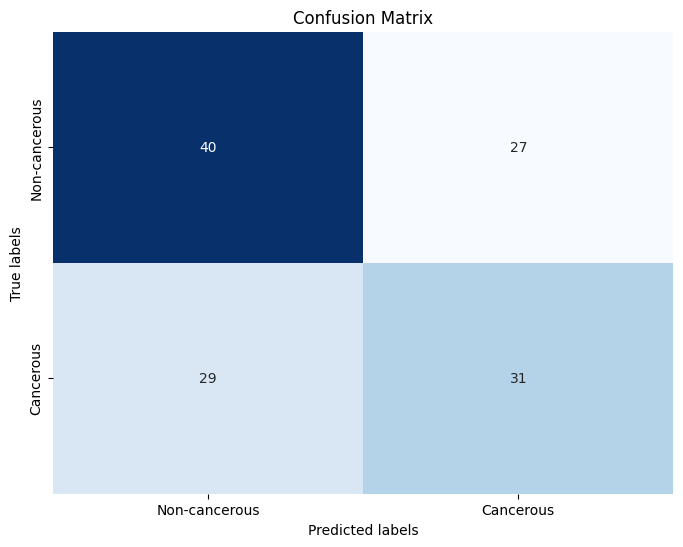

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_0.sav


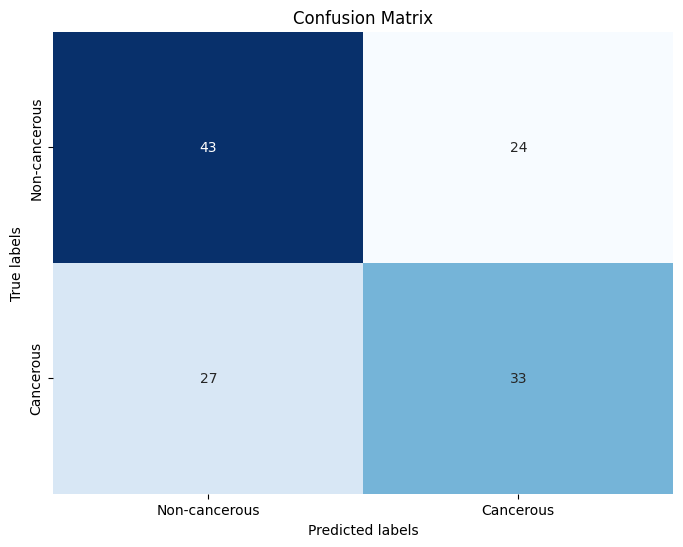

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_0.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_1.sav


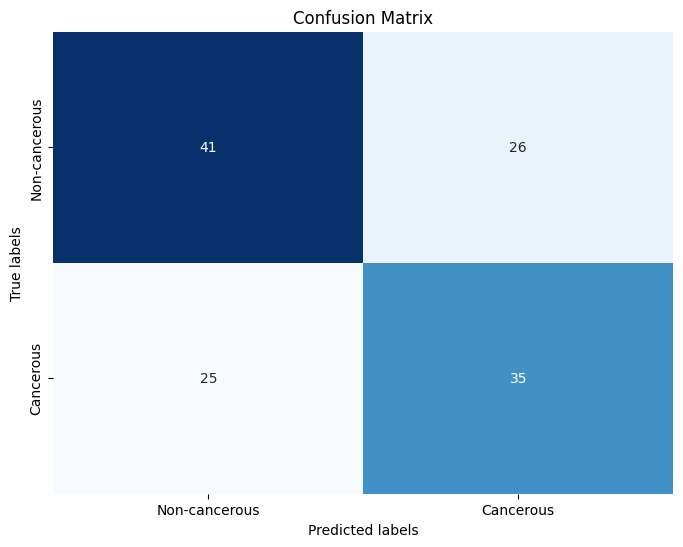

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_1.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_2.sav


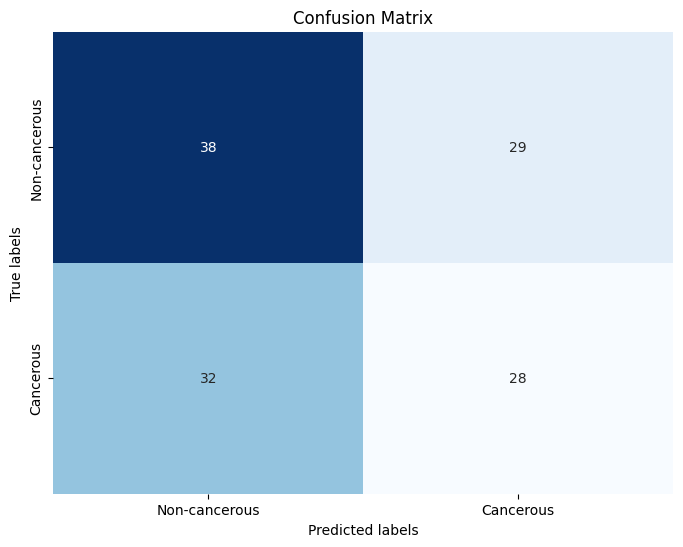

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_2.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_3.sav


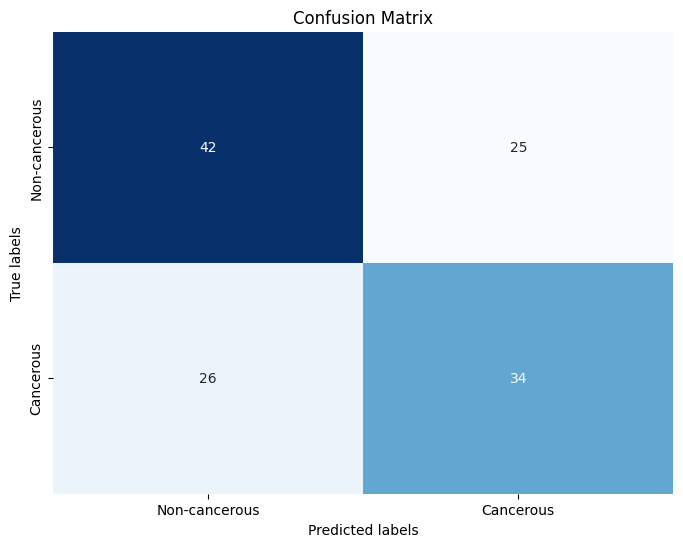

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_3.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_4.sav


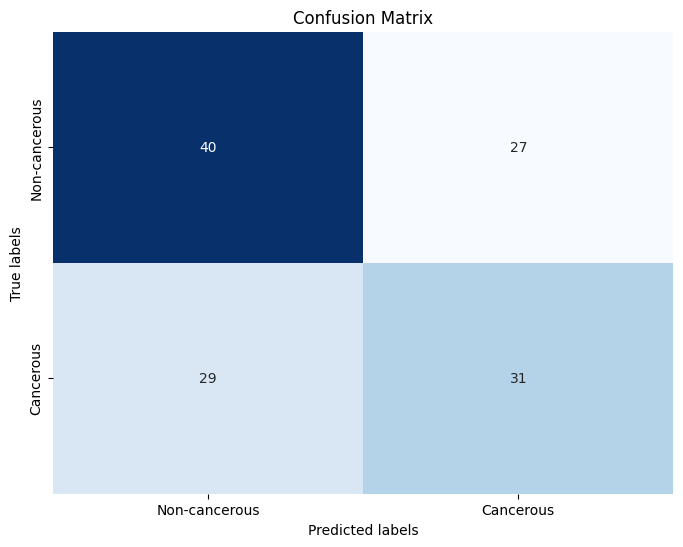

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_0_fold_4.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1.sav


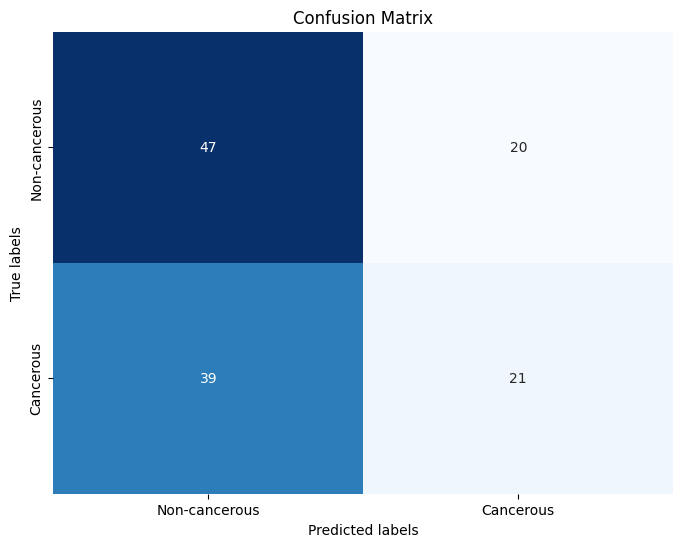

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_0.sav


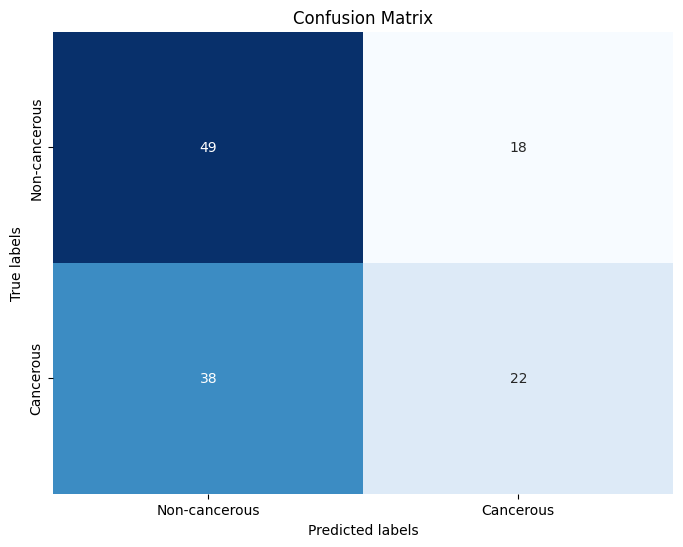

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_0.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_1.sav


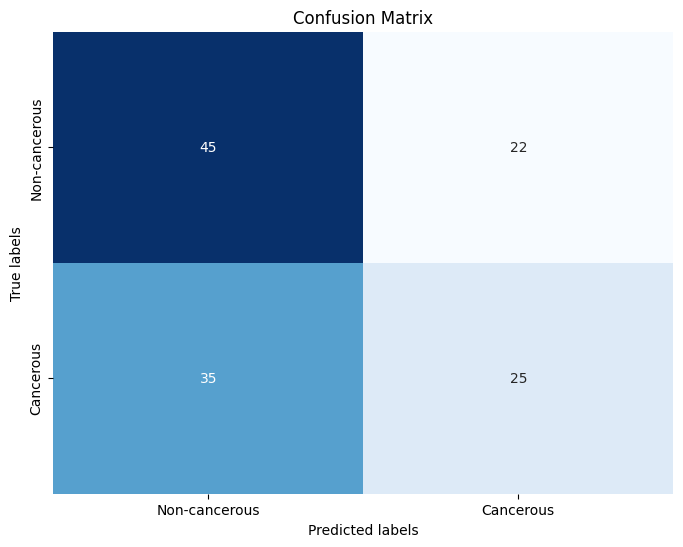

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_1.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_2.sav


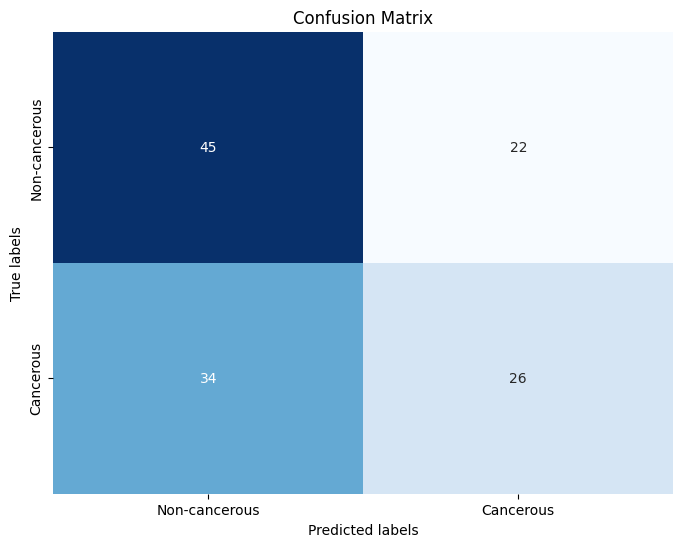

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_2.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_3.sav


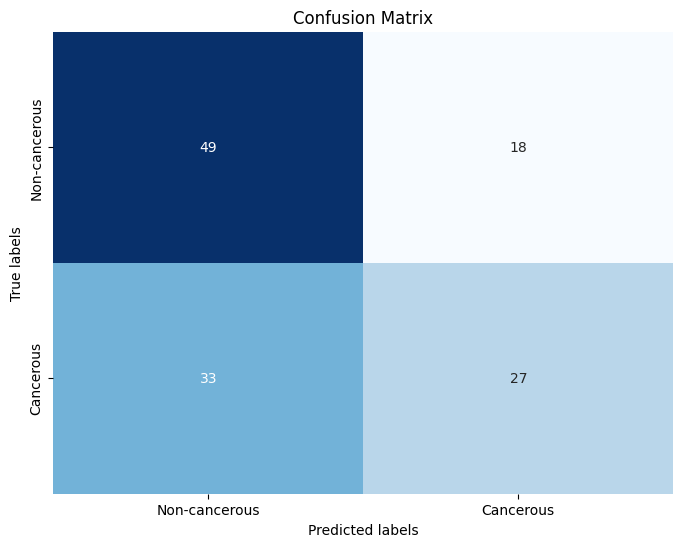

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_3.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_4.sav


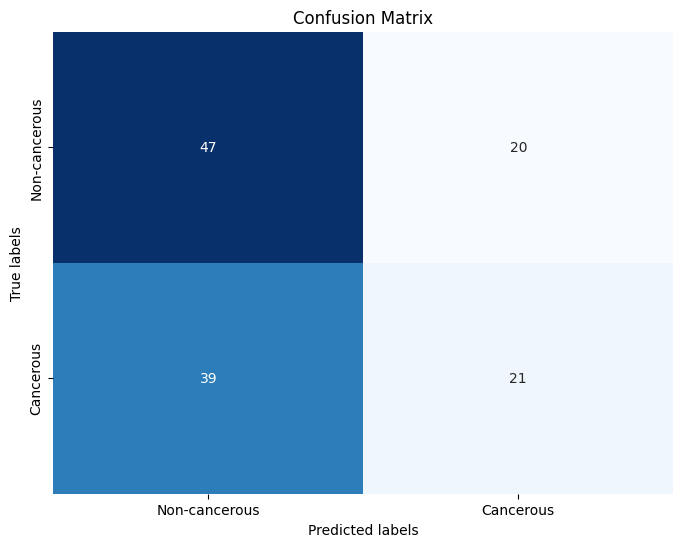

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_1_fold_4.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2.sav


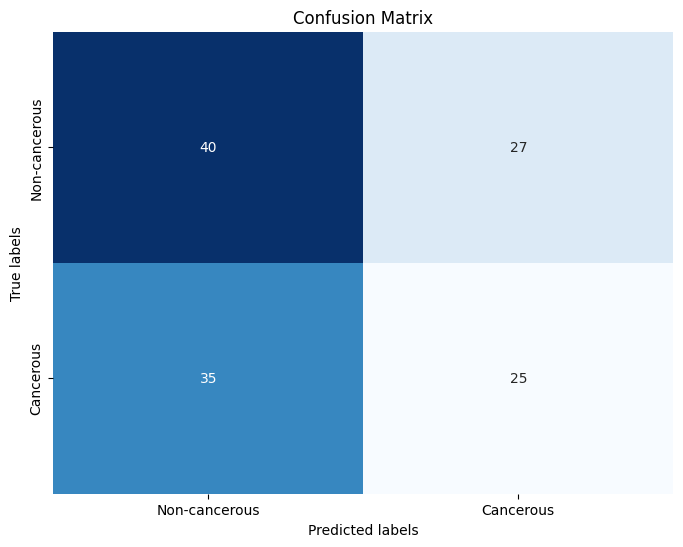

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_0.sav


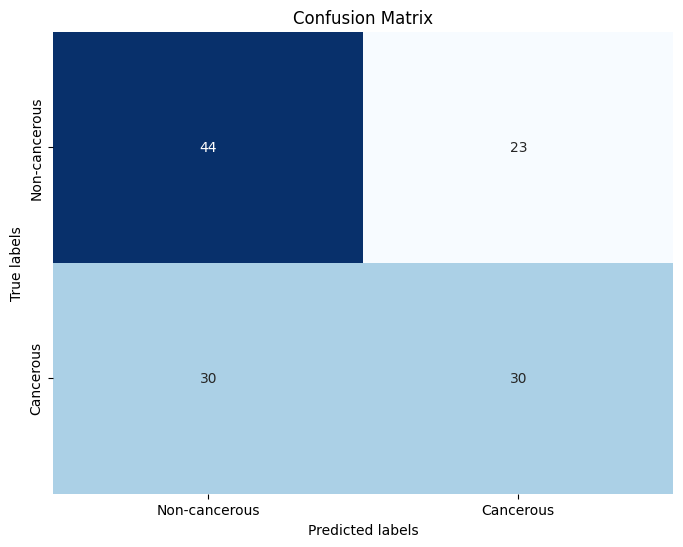

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_0.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_1.sav


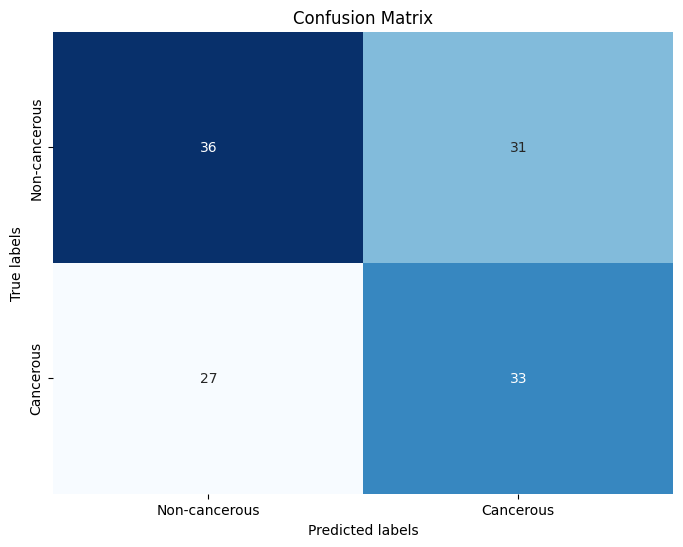

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_1.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_2.sav


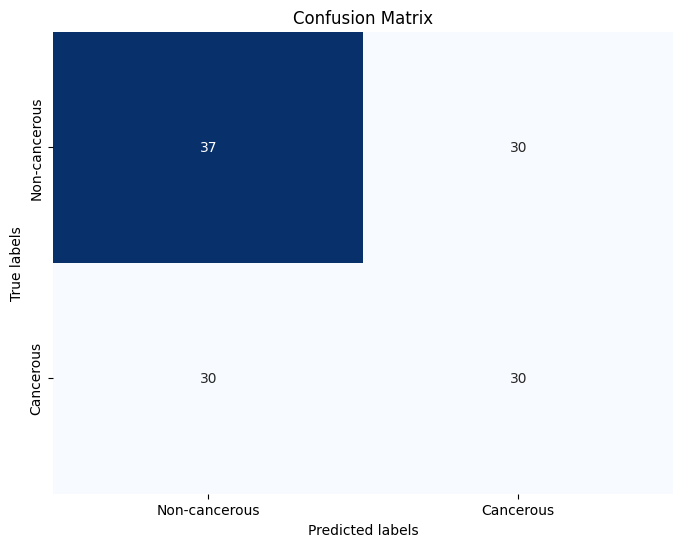

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_2.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_3.sav


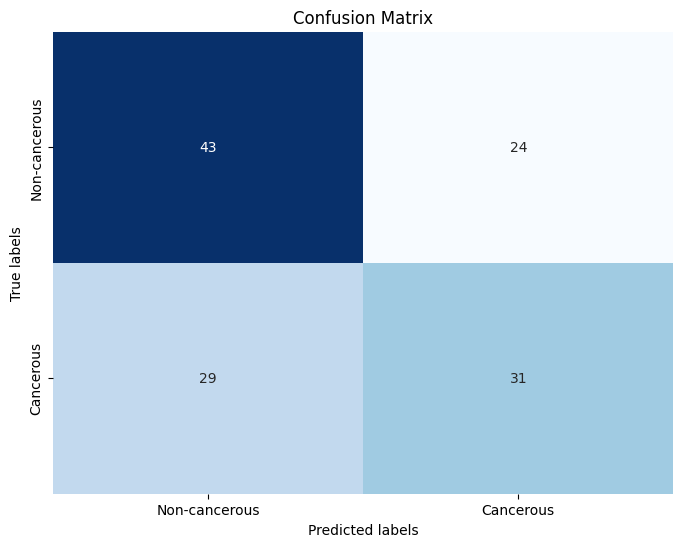

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_3.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_4.sav


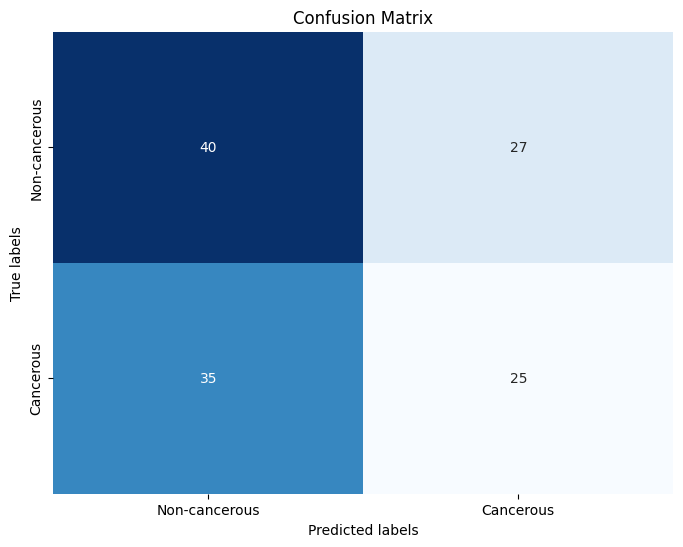

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_2_fold_4.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3.sav


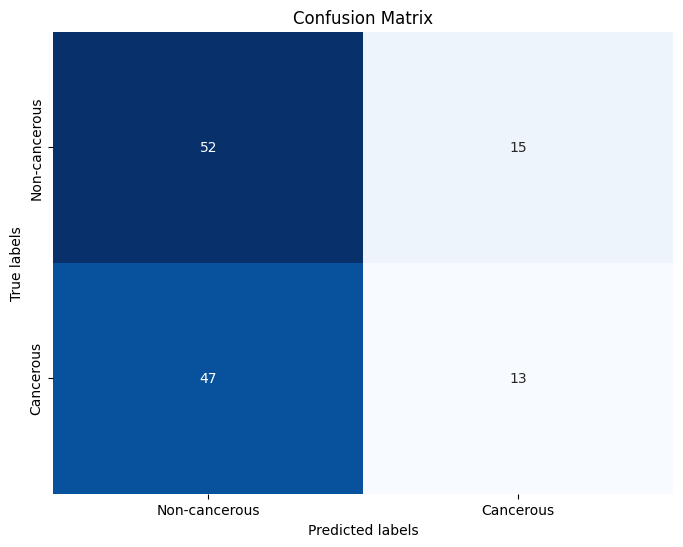

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_0.sav


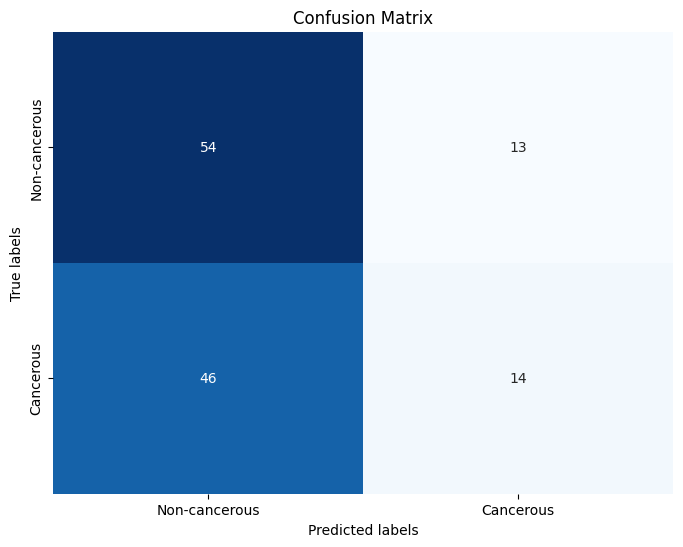

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_0.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_1.sav


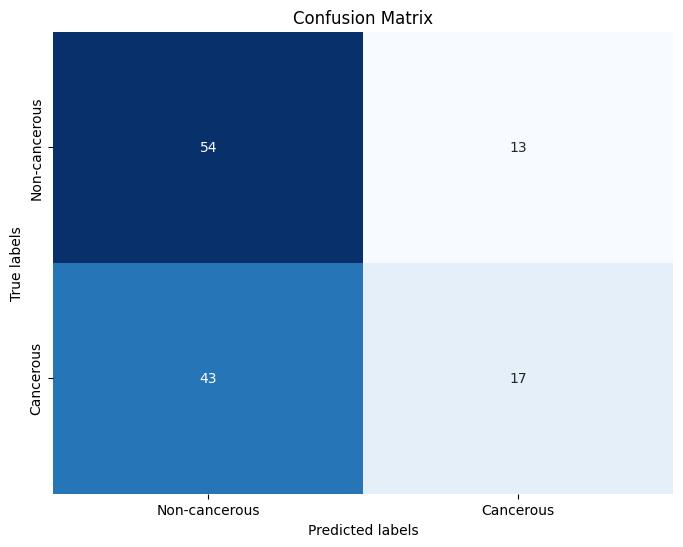

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_1.sav:
Accuracy: 0.5590551181102362
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_2.sav


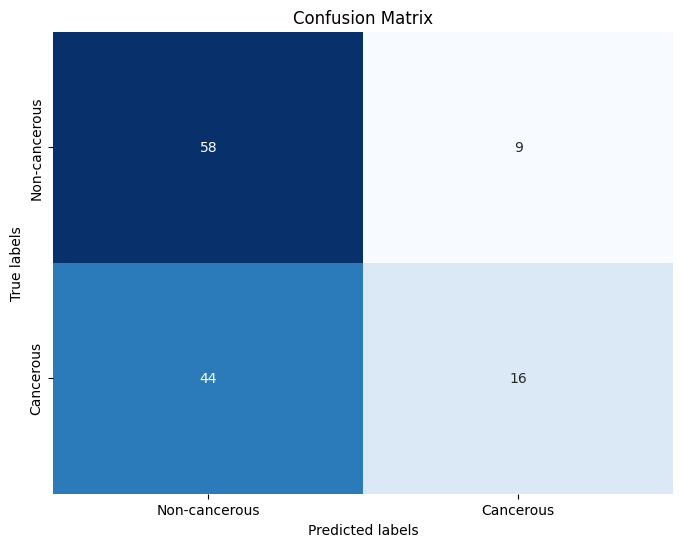

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_2.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_3.sav


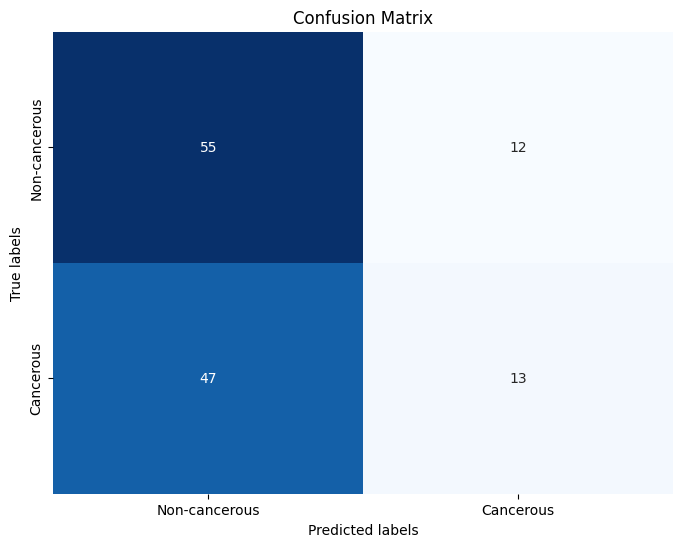

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_3.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_4.sav


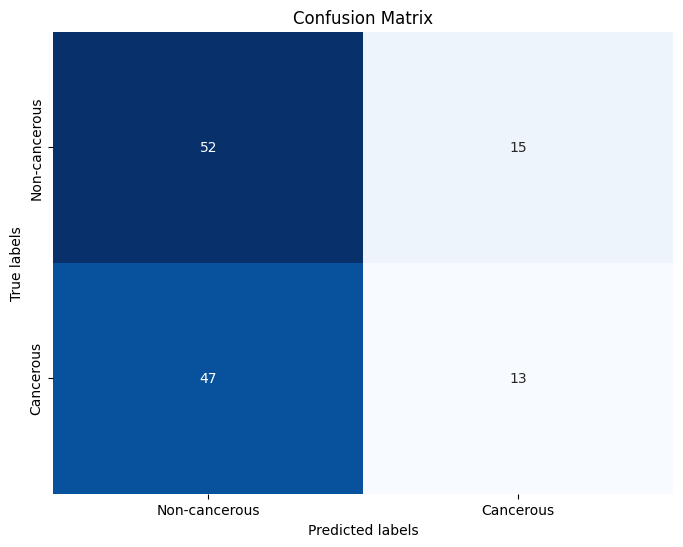

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_3_fold_4.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4.sav


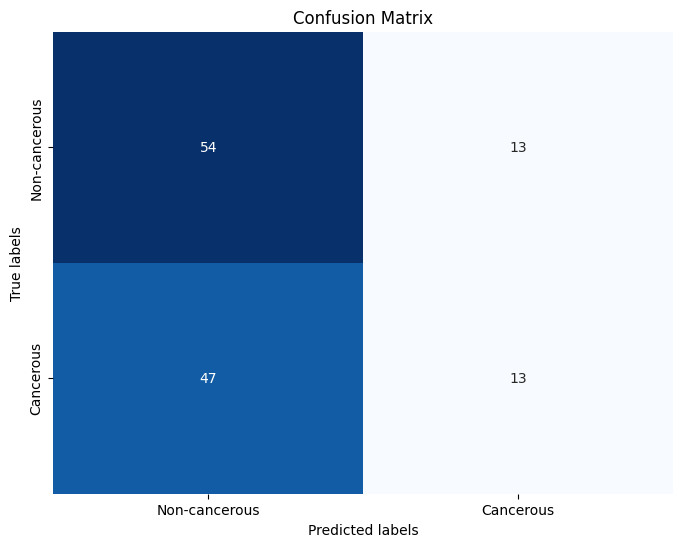

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_0.sav


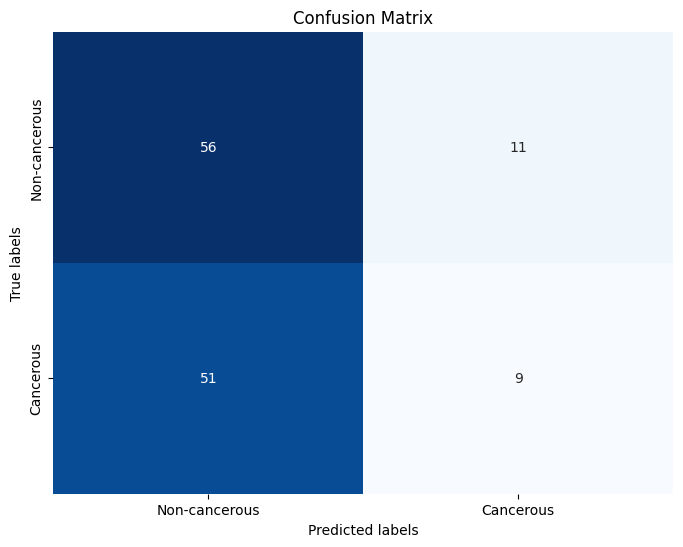

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_0.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_1.sav


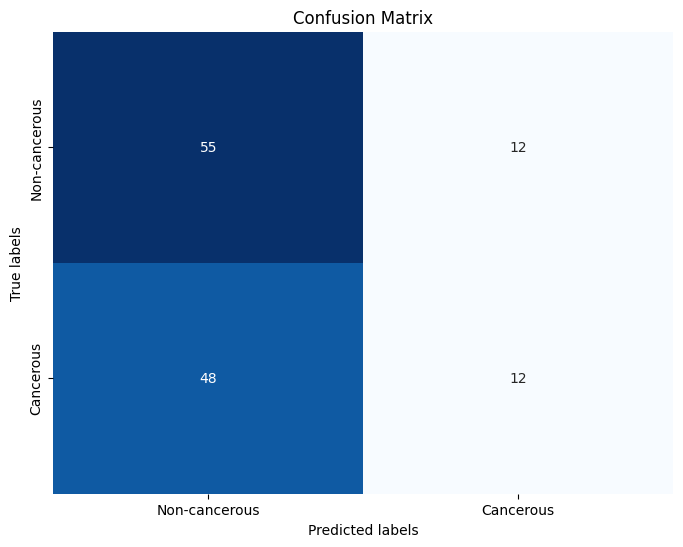

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_1.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_2.sav


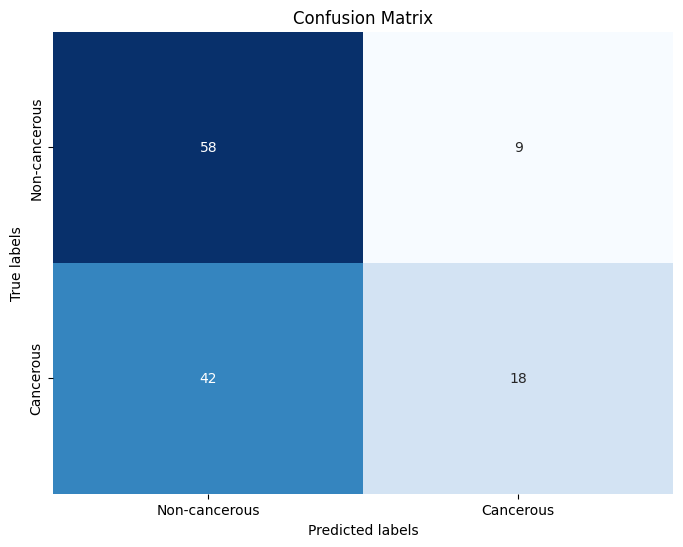

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_2.sav:
Accuracy: 0.5984251968503937
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_3.sav


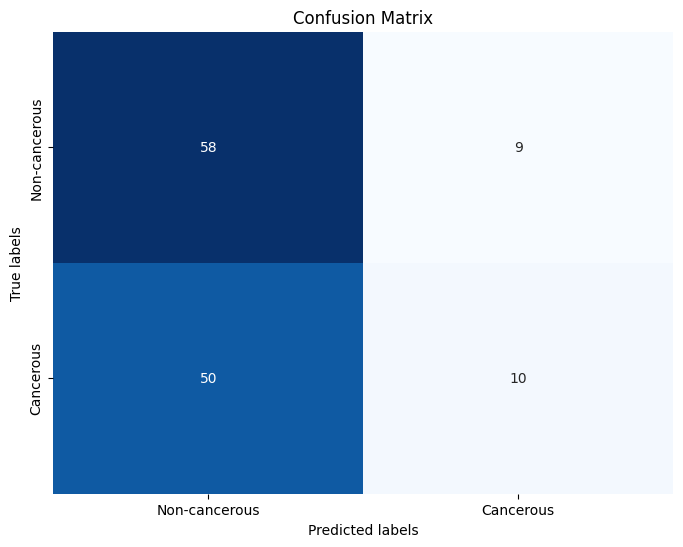

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_3.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_4.sav


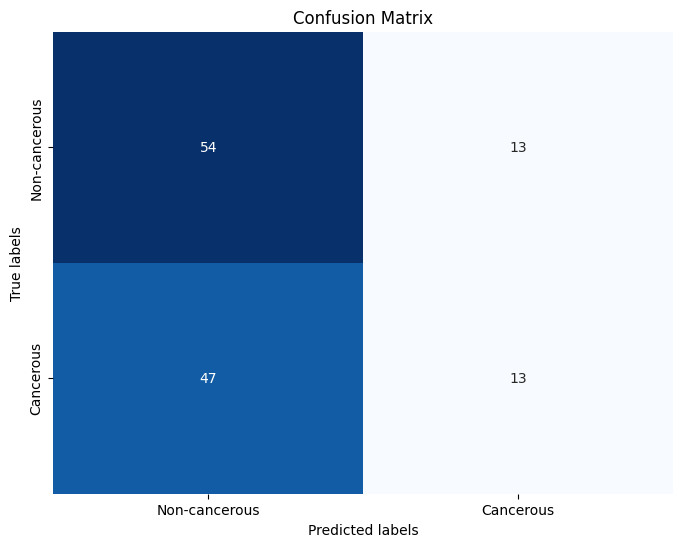

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_4_fold_4.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5.sav


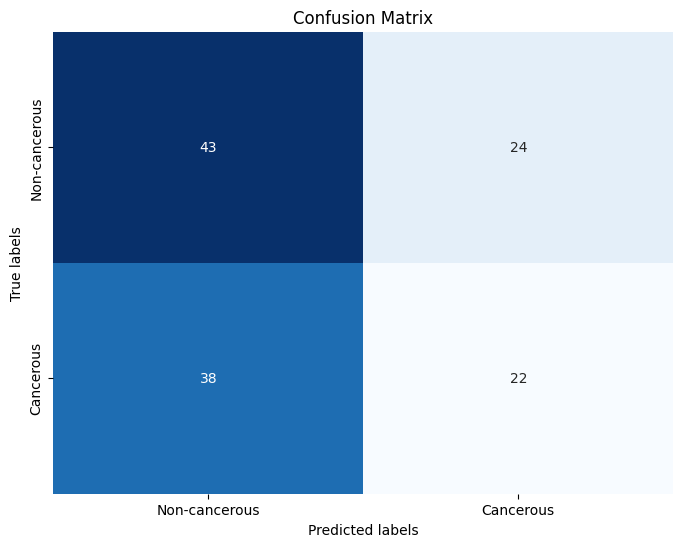

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_0.sav


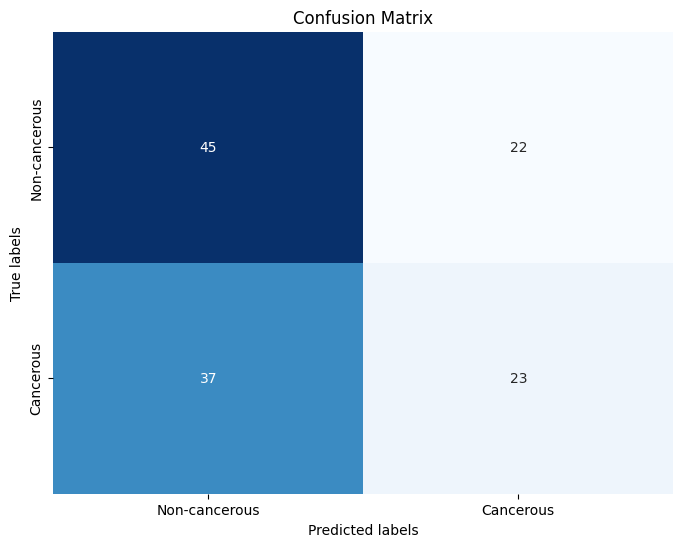

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_0.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_1.sav


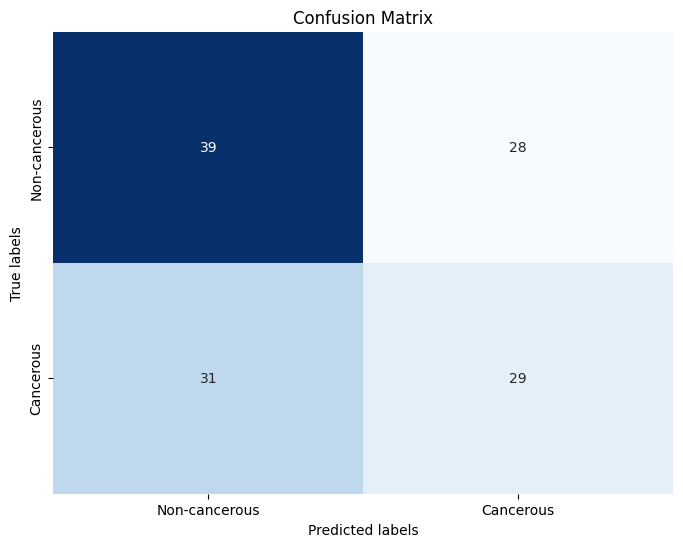

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_1.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_2.sav


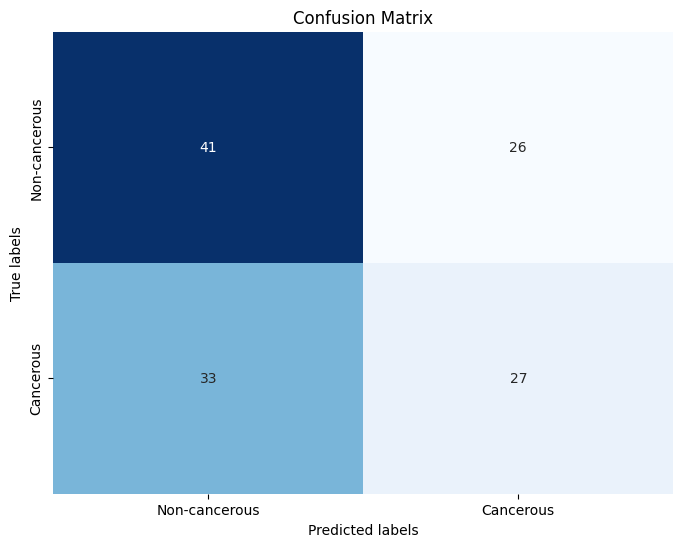

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_2.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_3.sav


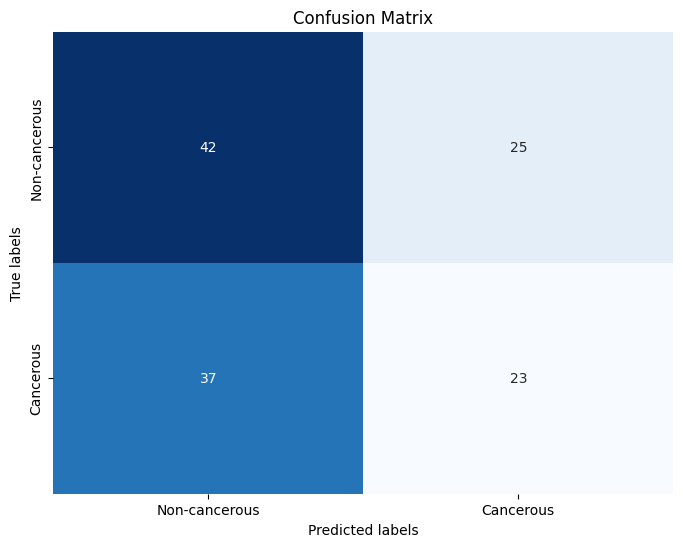

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_3.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_4.sav


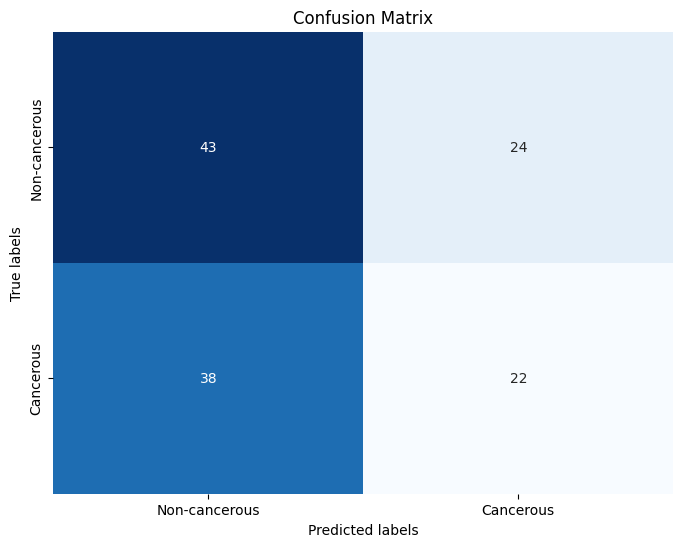

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_5_fold_4.sav:
Accuracy: 0.5118110236220472
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6.sav


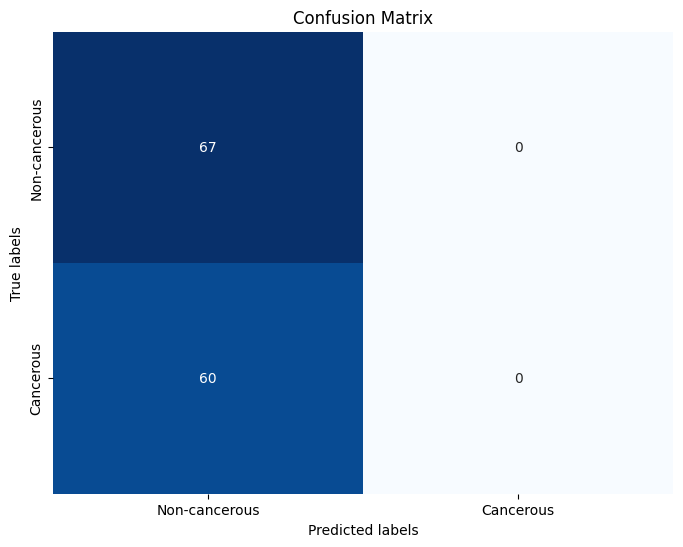

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_0.sav


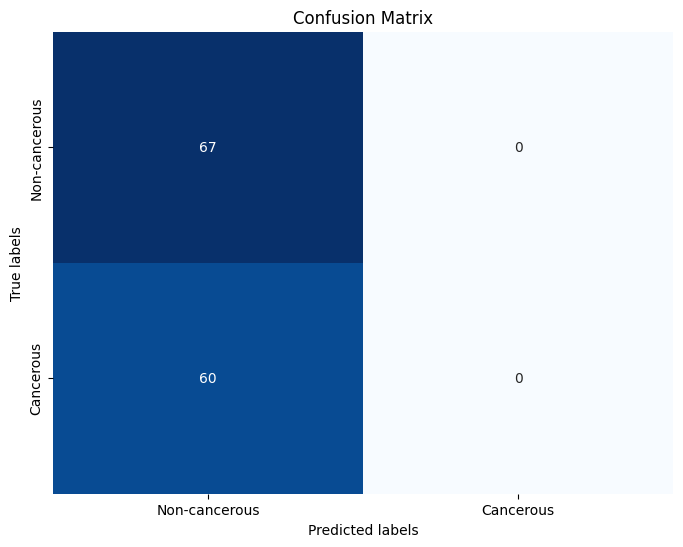

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_0.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_1.sav


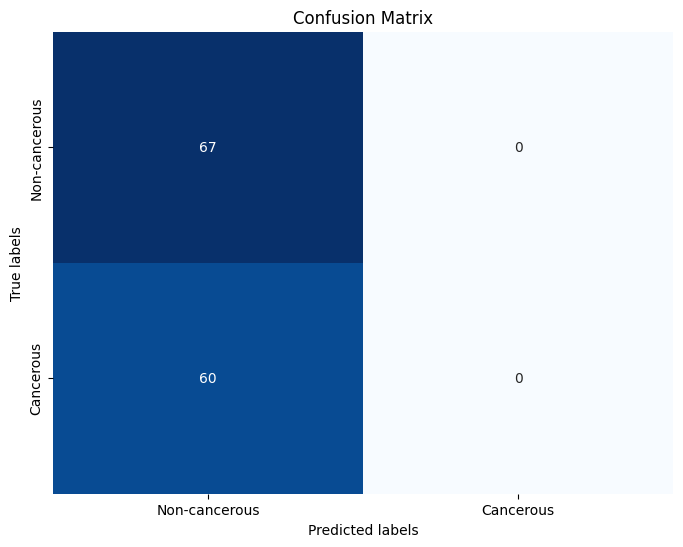

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_1.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_2.sav


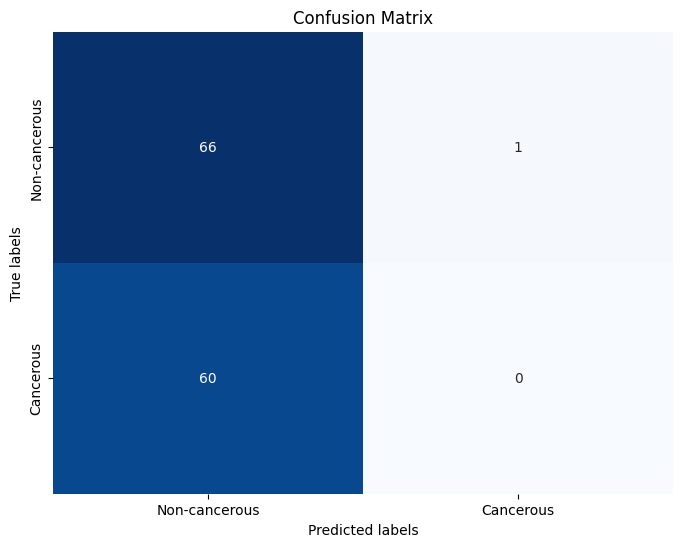

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_2.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_3.sav


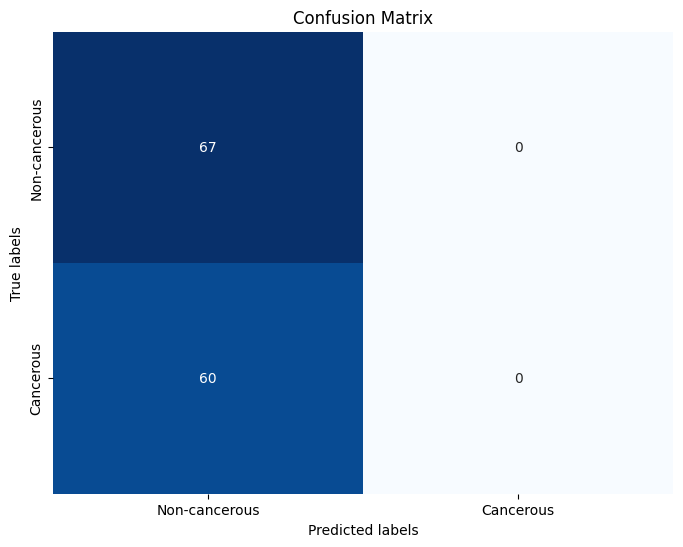

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_3.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_4.sav


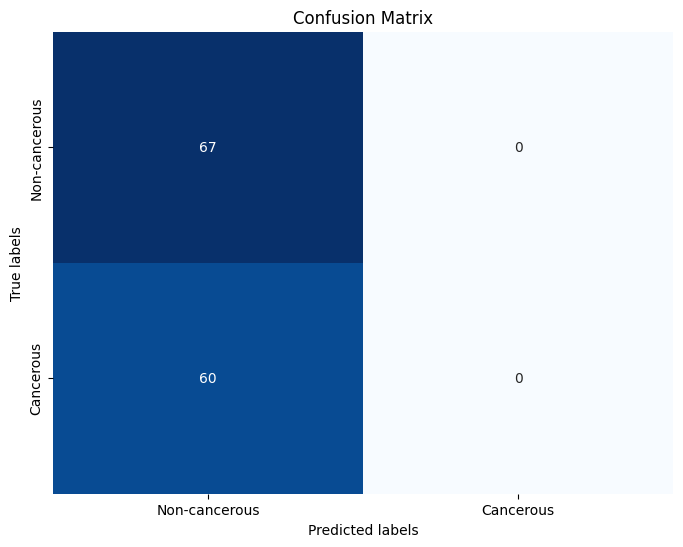

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_6_fold_4.sav:
Accuracy: 0.5275590551181102
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7.sav


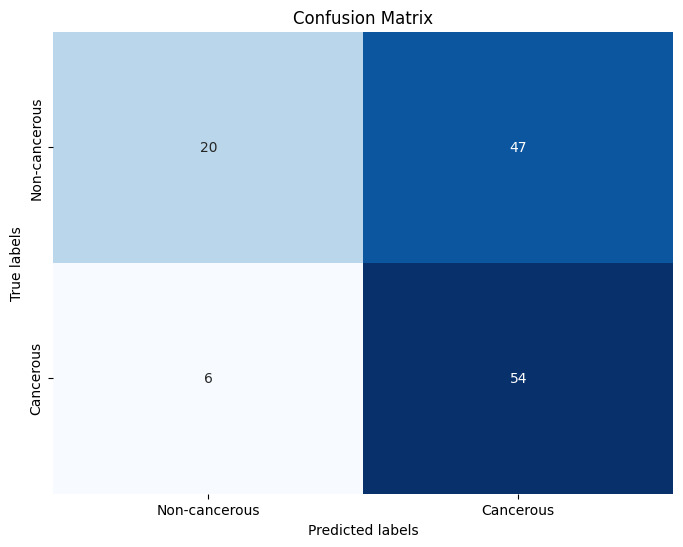

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_0.sav


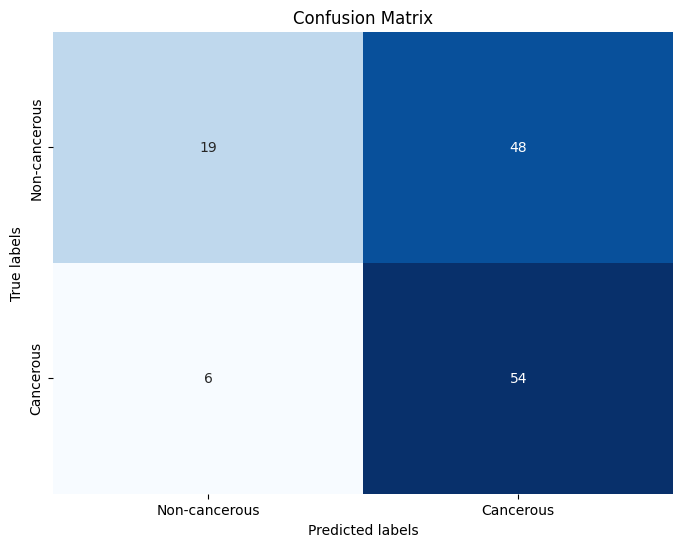

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_0.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_1.sav


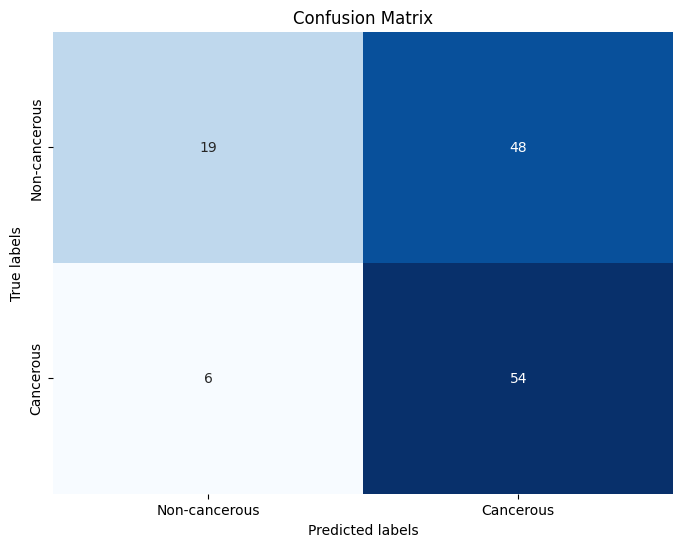

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_1.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_2.sav


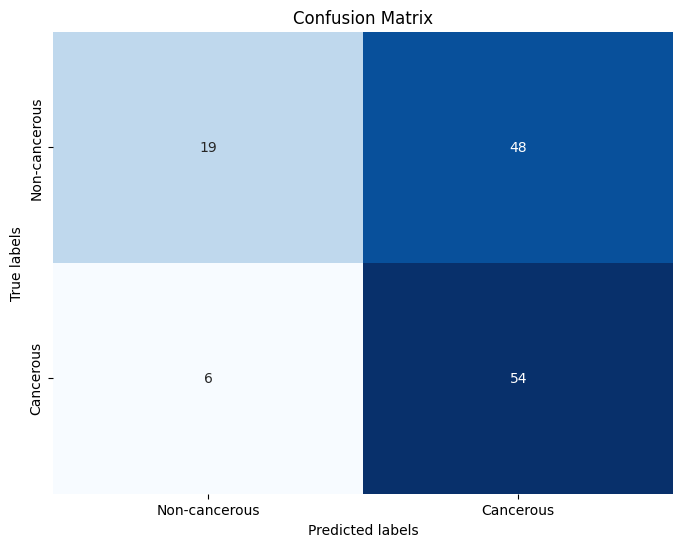

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_2.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_3.sav


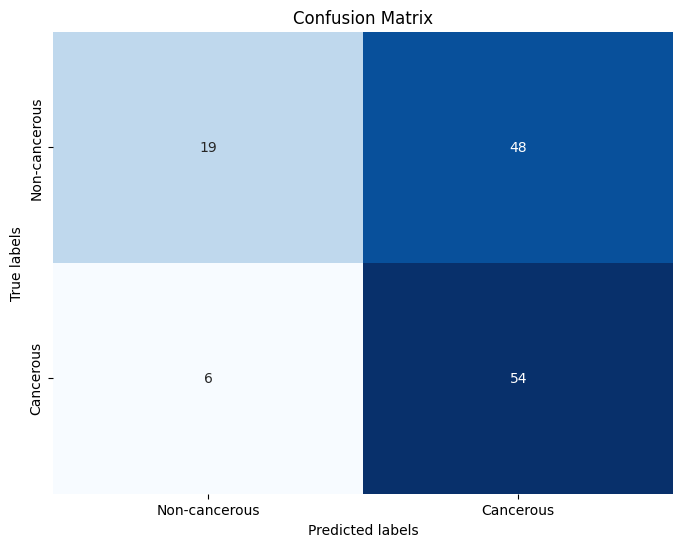

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_3.sav:
Accuracy: 0.5748031496062992
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_4.sav


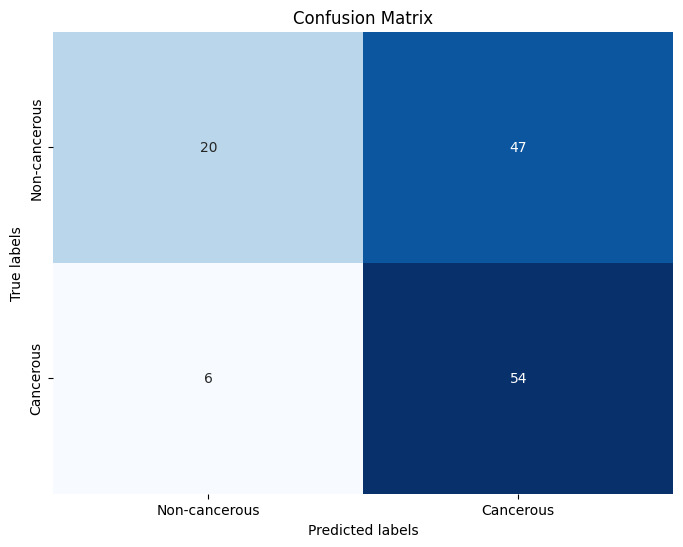

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_7_fold_4.sav:
Accuracy: 0.5826771653543307
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8.sav


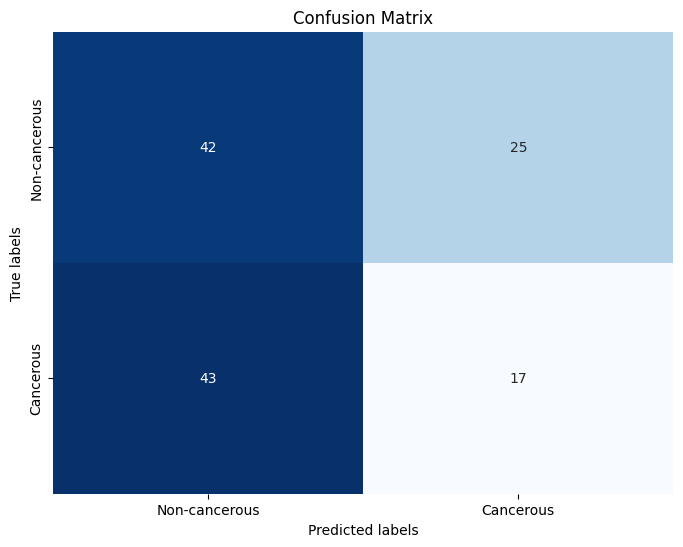

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8.sav:
Accuracy: 0.4645669291338583
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_0.sav


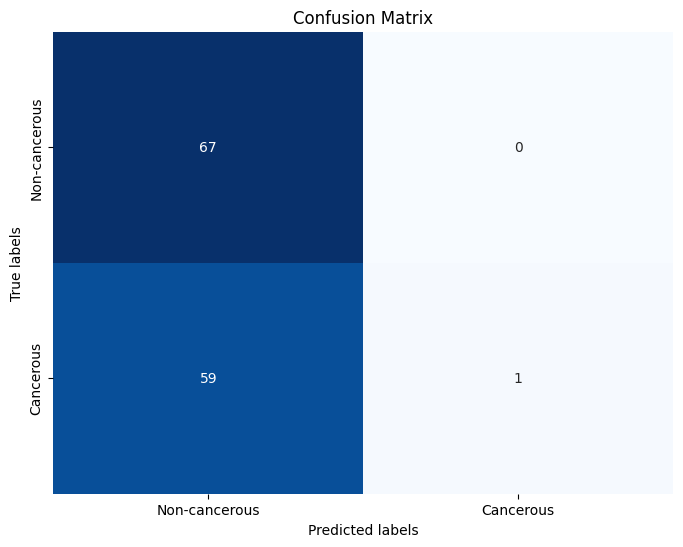

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_0.sav:
Accuracy: 0.5354330708661418
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_1.sav


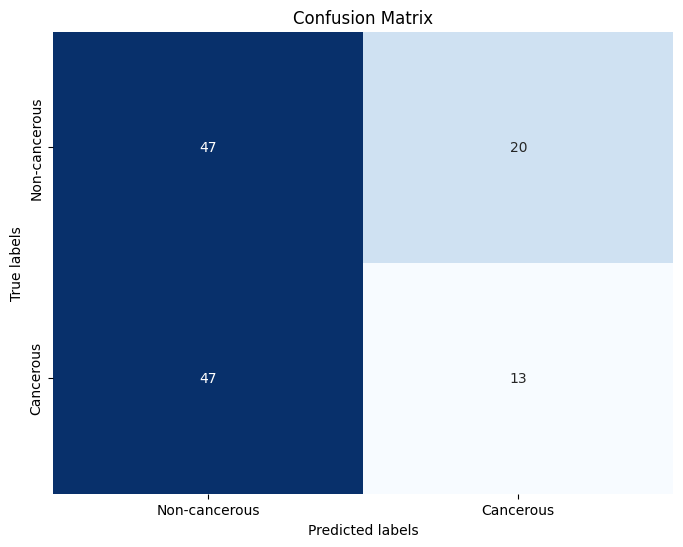

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_1.sav:
Accuracy: 0.47244094488188976
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_2.sav


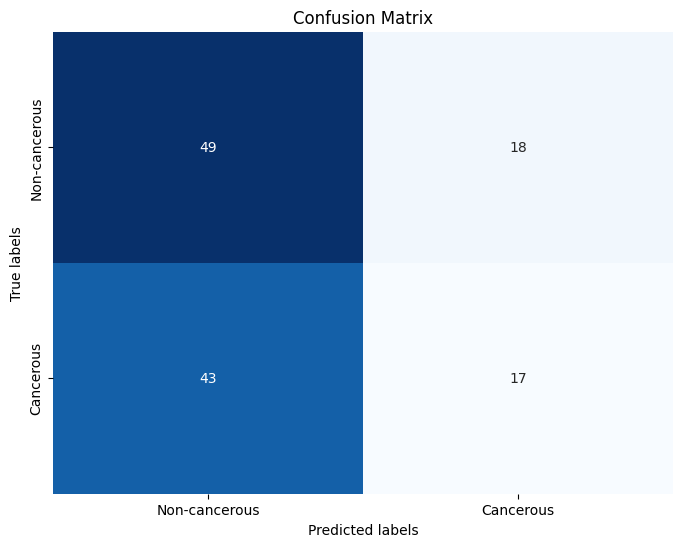

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_2.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_3.sav


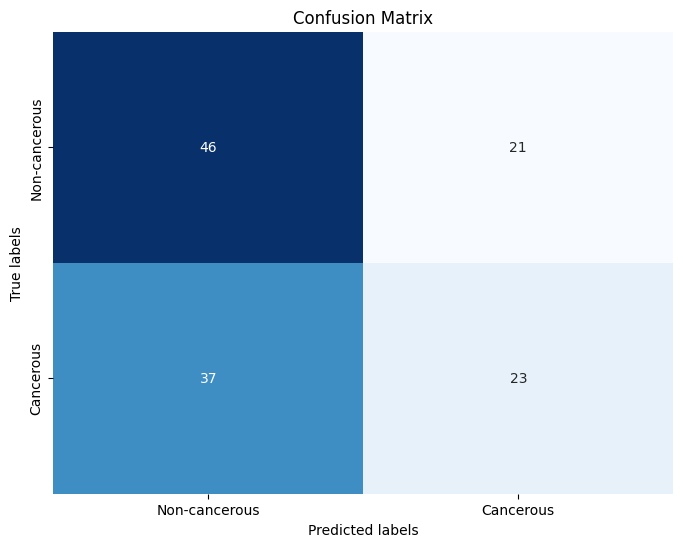

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_3.sav:
Accuracy: 0.5433070866141733
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_4.sav


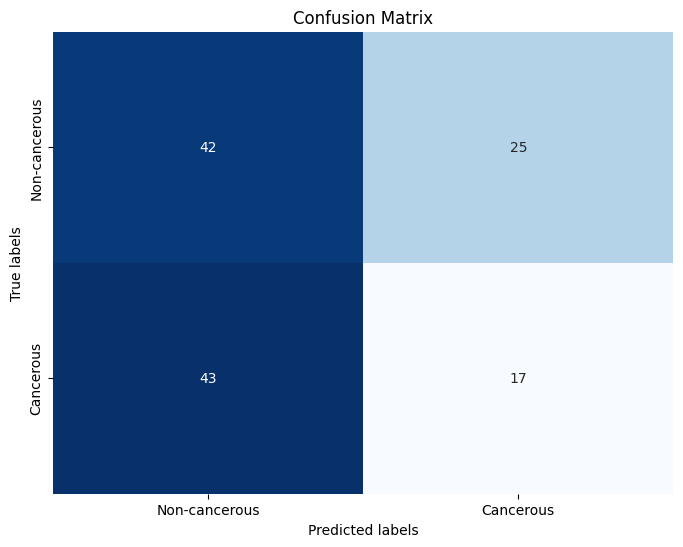

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_8_fold_4.sav:
Accuracy: 0.4645669291338583
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9.sav


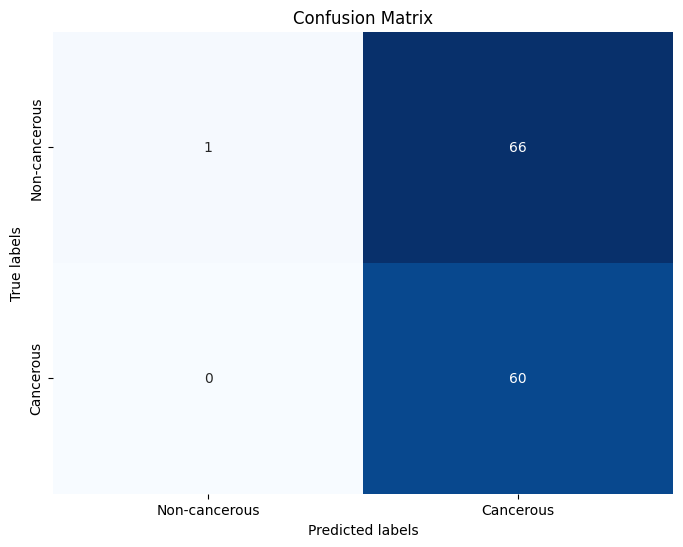

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9.sav:
Accuracy: 0.48031496062992124
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_0.sav


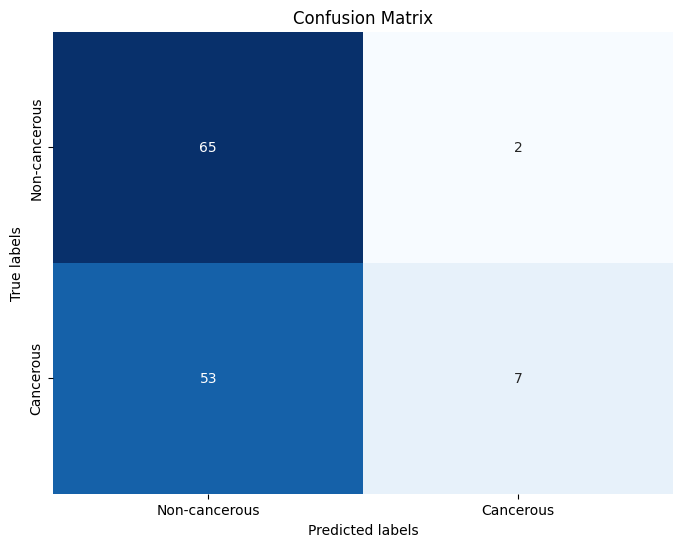

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_0.sav:
Accuracy: 0.5669291338582677
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_1.sav


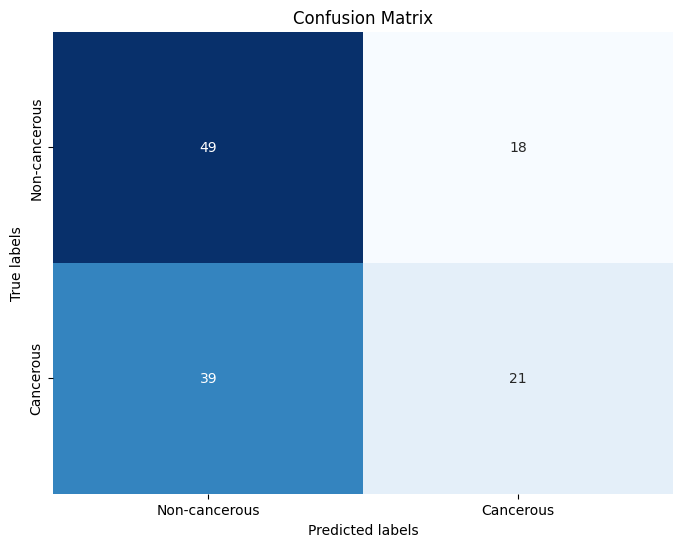

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_1.sav:
Accuracy: 0.5511811023622047
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_2.sav


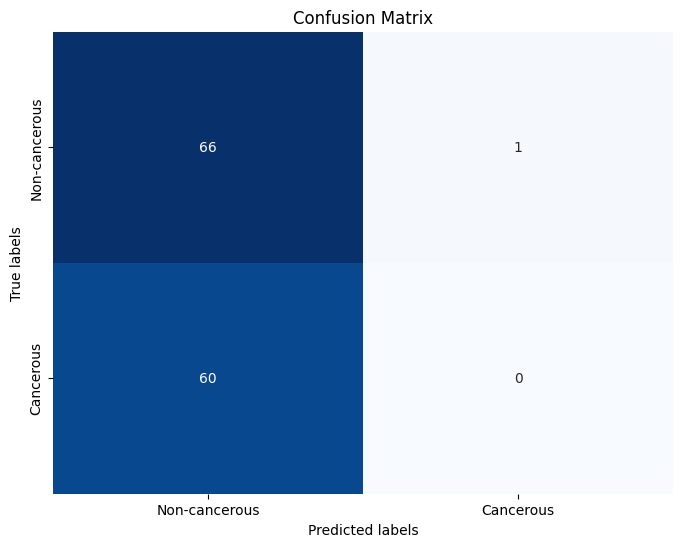

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_2.sav:
Accuracy: 0.5196850393700787
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_3.sav


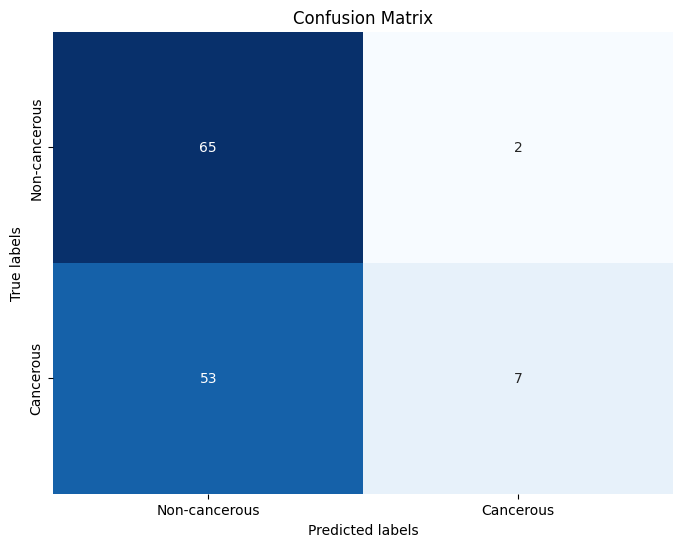

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_3.sav:
Accuracy: 0.5669291338582677
Loaded classifier from C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_4.sav


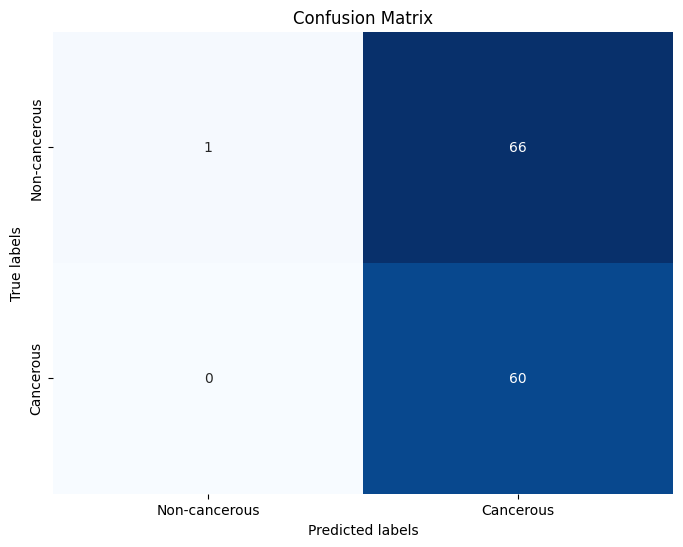

Results for C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024\classifier_9_fold_4.sav:
Accuracy: 0.48031496062992124


In [8]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import matplotlib.pyplot as plt
import seaborn as sns

#Defining path to metadata and testing set
data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_evaluate')
path_mask = os.path.join(data_dir, 'images', 'masks_evaluate')

feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(features_path, path_image, path_mask, feature_names)

# Loading metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Defining the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['diagnostic'].apply(lambda x: 1 if x in cancerous_conditions else 0)
y = combined_df['target'].values
X = combined_df[feature_names].values
patient_id = combined_df['patient_id']

def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Non-cancerous', 'Cancerous'],
                yticklabels=['Non-cancerous', 'Cancerous'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, cm

# Using glob to find all classifier files
classifier_dir = r"C:\Users\katya\ITU\2 semester\Project in Data Science\Project_data_science_queen_snakes\fyp2024"
classifier_filenames = glob.glob(os.path.join(classifier_dir, '*.sav'))

# Evaluating all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    if accuracy is not None:
        print(f"Results for {model_filename}:")
        print("Accuracy:", accuracy)



In [10]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from extract_features import  process_images

data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_original')
path_mask = os.path.join(data_dir, 'images', 'masks_original')

#Define features to use in classification
feature_names = ['assymetry', 'colours', 'dots and globules', 'compactness']
features_df = df_features
# Load metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Define the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['diagnostic'].apply(lambda x: 1 if x in cancerous_conditions else 0)

# Load model and predict probabilities
def predict_probabilities(model_filename, X):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
        probabilities = classifier.predict_proba(X)
        return probabilities
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return None

#Define pass to the model 
model_filename = r"classifier_7.sav"


# Create a list to save probabilities with patient id and labels
results = []

probabilities = predict_probabilities(model_filename, features_df[feature_names].values)
if probabilities is not None:
    # Iterate over each prediction and corresponding image ID
    for idx, prob in enumerate(probabilities):
        results.append({
            'Patient ID': combined_df.iloc[idx]['patient_id'],
            'Image ID': features_df.iloc[idx]['image_id'],
            'Probability Non-cancerous': prob[0],  # Assuming 0 is non-cancerous
            'Probability Cancerous': prob[1],     # Assuming 1 is cancerous
            'Actual Label': combined_df.iloc[idx]['target']  # Ensure target column exists
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Define the Excel writer and the path for the Excel file
excel_path = 'predictions_new.xlsx'


# Write DataFrame to an Excel file
results_df.to_excel(excel_path, index=False)


print(f"Predictions have been saved to {excel_path}")


Loaded classifier from classifier_7.sav
Predictions have been saved to predictions_new.xlsx
